Ocena 3.0

1. Konwersja notacji na ścieżki:

• Zamień każdą strukturę wejściową w ścieżkę tj. sekwencję stanów P lub N , gdzie:

– Znak inny niż kropka (.) przyjmuje stan P

– Kropka (.) przyjmuje stan N

2. Wyznaczanie prawdopodobieństw zmiany stanów:

• Oblicz częstość występowania każdej pary stanów (P P , P N , N P , N N ) wśród wszystkich wygenerowanych ścieżek

• Prawdopodobieństwo zmiany stanu z jednego na drugi to stosunek liczby wystąpień danej pary do całkowitej liczby przejść ze stanu pierwszego (np. częstość P P dzielona przez sumę częstości P P i P N )

3. Wyznaczanie prawdopodobieństw emisji symboli:

• Dla każdego stanu (P i N ), zlicz wystąpienia symboli (np. A, C, . . . ) w całym zbiorze danych

• Prawdopodobieństwo emisji danego symbolu w określonym stanie to stosunek liczby wystąpień danego symbolu w tym stanie do całkowitej liczby wystąpień tego stanu

Przedstaw wyniki w postaci tabel A (zmiany stanów) i E (emisji symboli)


In [41]:
import pandas as pd
from collections import Counter

data = []
with open('RF01739.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('>'):
            header = line[1:]
        elif all(char in 'AGCU' for char in line):
            sequence = line
        else:
            structure = line
            data.append((header, sequence, structure))

def convert(structure):
    return ''.join(['P' if char != '.' else 'N' for char in structure])

paths = [convert(structure) for _, _, structure in data]

transition_counts = Counter()
total_transitions = {'P': 0, 'N': 0}

for path in paths:
    for i in range(len(path) - 1):
        pair = path[i] + path[i + 1]
        transition_counts[pair] += 1
        total_transitions[path[i]] += 1

A = {
    'P->P': transition_counts['PP'] / total_transitions['P'] if total_transitions['P'] else 0,
    'P->N': transition_counts['PN'] / total_transitions['P'] if total_transitions['P'] else 0,
    'N->P': transition_counts['NP'] / total_transitions['N'] if total_transitions['N'] else 0,
    'N->N': transition_counts['NN'] / total_transitions['N'] if total_transitions['N'] else 0
}

symbol_counts = {'P': Counter(), 'N': Counter()}
total_states = {'P': 0, 'N': 0}

for (_, sequence, structure) in data:
    path = convert(structure)
    for state, symbol in zip(path, sequence):
        symbol_counts[state][symbol] += 1
        total_states[state] += 1

E = {
    'P': {symbol: symbol_counts['P'][symbol] / total_states['P'] for symbol in 'ACGU'},
    'N': {symbol: symbol_counts['N'][symbol] / total_states['N'] for symbol in 'ACGU'}
}


A_table = pd.DataFrame(A, index=["Probability"])
print("A Table (State changes):")
print(A_table)


E_table = pd.DataFrame(E).transpose()
print("\nE Table (Symbol emissions):")
print(E_table)





A Table (State changes):
                 P->P      P->N      N->P      N->N
Probability  0.739436  0.260564  0.237539  0.762461

E Table (Symbol emissions):
          A         C         G         U
P  0.198803  0.289225  0.301435  0.210537
N  0.433915  0.108854  0.227567  0.229664


Ocena 3.5

Zaimplementuj algorytm Viterbiego do określania ścieżki o największym prawdopodobieństwie dla zadanej sekwencji. Uwaga, dla tego zbioru danych nie ma potrzeby korzystania z poprawki, w której mnożenia prawdopodobieństw zastępowane są dodawaniem ich logarytmów.

• Stwórz dwie tabele V i T , obie o wymiarach 2xL (gdzie 2 to liczba stanów, a L to długość sekwencji)

• Wypełnij pierwszą kolumnę dla każdego stanu s i indeksu 0 (odpowiadającemu pierwszej literze w sekwencji):
Vs,0 = Es,0

• Wypełnij tabelę dla każdego stanu t oraz każdej pozycji w sekwencji i, biorąc pod uwagę każdymożliwy stan wcześniejszy s:

Vt,i = Et,i · max

s (Vs,i−1 · As,t)

Tt,i = s

Aby odczytać wynik:

• Stwórz listę R o długości L

• Ostatni stan na ścieżce R to ten, który ma maksymalną wartość w ostatniej kolumnie tabeli V (w notacji tutaj przyjmuje wszędzie indeksowanie od zera, więc ostatnia kolumna ma indeks L − 1):

RL−1 = arg max

s Vs,L−1

• Wcześniejsze indeksy i = L − 2, . . . , 0 wypełnij na podstawie tabeli T :

Ri = TRi+1,i+1

Następnie uruchom algorytm Viterbiego dla każdej sekwencji i porównaj wygenerowane ścieżki z prawdziwymi danymi. Do porównania oblicz procent stanów, które się pokrywają (jak często zgadzało się P w sekwencji z algorytmu z P pochodzącym z danych). 
Przedstaw wynik w postaci wykresu
pudełkowego.

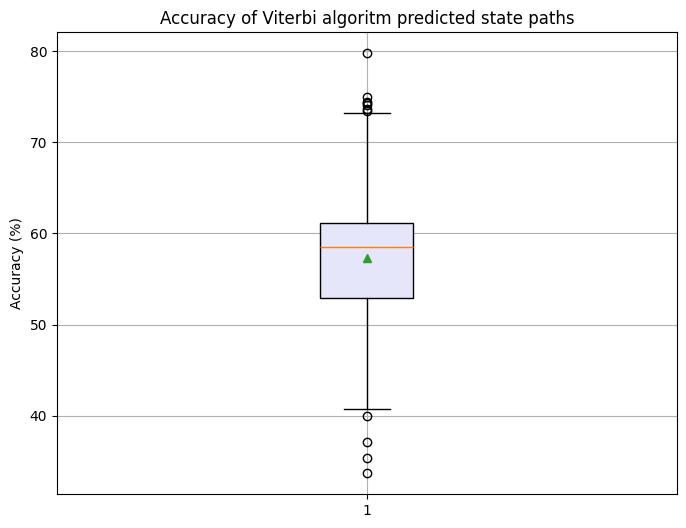

In [61]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def viterbi(sequence, A, E):
    states = ['P', 'N']
    L = len(sequence) 

    V = np.zeros((2, L))
    T = np.zeros((2, L), dtype=int)

    for i, state in enumerate(states):
        V[i, 0] = E[state].get(sequence[0], 0)

    for t in range(1, L):
        for i, state in enumerate(states):
            probabilities = [
                V[k, t - 1] * A.get(f"{states[k]}->{state}", 0) * E[state].get(sequence[t], 0)
                for k in range(2)
            ]
            V[i, t] = max(probabilities)  
            T[i, t] = np.argmax(probabilities)

    best_path = [np.argmax(V[:, -1])] 
    for t in range(L - 1, 0, -1):
        best_path.insert(0, T[best_path[0], t]) 

    return ''.join(['P' if state == 0 else 'N' for state in best_path])

results = []
results_percentage = []

for _, sequence, structure in data:
    original_structure = convert(structure) 
    pred_structure = viterbi(sequence, A, E)  
    results.append(pred_structure)

    matches = sum(1 for p, t in zip(pred_structure, original_structure) if p == t)
    result_percentage = (matches / len(sequence)) * 100
    results_percentage.append(result_percentage)

plt.figure(figsize=(8, 6))
plt.boxplot(results_percentage, patch_artist=True, showmeans=True, boxprops=dict(facecolor="#E6E6FA"))
plt.title("Accuracy of Viterbi algoritm predicted state paths")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()



Ocena 4.0

Zaimplementuj algorytmy forward i backward, również bez poprawek na mnożenie prawdopodobieństw.

Algorytm forward:

• Stwórz tabelę F o wymiarach 2xL

• Wypełnij pierwszą kolumnę tak jak V

• Wypełnij tabelę dla każdego stanu t oraz każdej pozycji w sekwencji i, biorąc pod uwagę każdy możliwy stan wcześniejszy s:

Ft,i = Et,i · ∑

s

(Fs,i−1 · As,t)


Algorytm backward:

• Stwórz tabelę B o wymiarach 2xL

• Wypełnij ostatnią kolumnę wartościami 1 dla każdego stanu s:

Bs,L−1 = 1

• Wypełnij tabelę dla każdego stanu s oraz każdej pozycji w sekwencji i = L − 2, . . . , 0, biorąc pod uwagę każdy możliwy stan późniejszy t:

Bs,i = ∑

t

(Bt,i+1 · As,t · Et,i+1)

Wyznacz prawdopodobieństwo sekwencji x na dwa sposoby:

P1(x) = ∑

s

Fs,L−1

P2(x) = ∑

s

(Es,0 · Bs,0)

Wyniki powinny być sobie równe (z dokładnością do precyzji obliczeń). Wykaż, że tak jest obliczając wartość bezwzględną różnic obu prawdopodobieństw dla każdej sekwencji wejściowej. Przedstaw tak zebrane wyniki na wykresie pudełkowym.

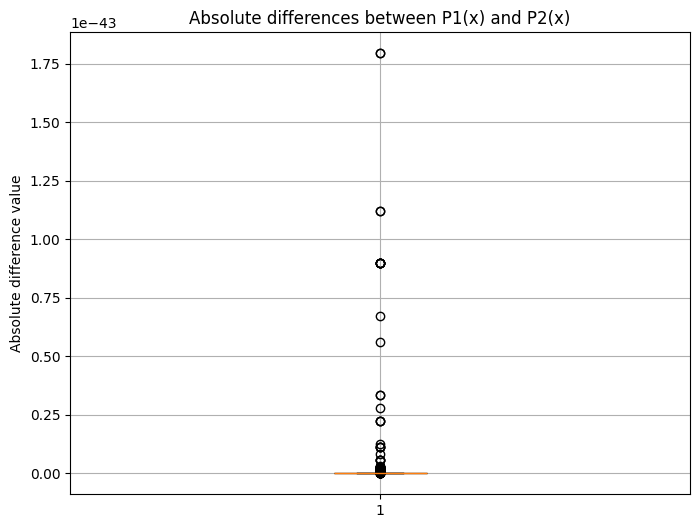

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def forward(sequence, A, E):
    states = ['P', 'N']
    L = len(sequence)
    F = np.zeros((2, L))

    for i, state in enumerate(states):
        F[i, 0] = E[state].get(sequence[0], 0)

    for i in range(1, L):
        for t, state in enumerate(states):
            F[t, i] = E[state].get(sequence[i], 0) * sum(
                F[s, i - 1] * A.get(f"{states[s]}->{state}", 0) for s in range(2)
            )

    return F


def backward(sequence, A, E):
    states = ['P', 'N']
    L = len(sequence)
    B = np.zeros((2, L))

    for i in range(2):
        B[i, L - 1] = 1 

    for i in range(L - 2, -1, -1):
        for s, state in enumerate(states):
            B[s, i] = sum(
                B[t, i + 1] * A.get(f"{state}->{states[t]}", 0) * E[states[t]].get(sequence[i + 1], 0)
                for t in range(2)
            )

    return B


def calculate_probabilities(sequence, F, B, E):

    P1 = sum(F[:, -1]) 
    P2 = sum(
        E[state].get(sequence[0], 0) * B[s, 0]
        for s, state in enumerate(['P', 'N'])
    )
    return P1, P2


abs_differences = []

for _, sequence, structure in data:
    F = forward(sequence, A, E)
    B = backward(sequence, A, E)

    P1, P2 = calculate_probabilities(sequence, F, B, E)

    abs_difference = abs(P1 - P2)
    abs_differences.append(abs_difference)

plt.figure(figsize=(8, 6))
plt.boxplot(abs_differences, patch_artist=True, showmeans=False)
plt.title("Absolute differences between P1(x) and P2(x)")
plt.ylabel("Absolute difference value")
plt.grid(True)
plt.show()


Ocena 4.5

Dysponując tabelami F i B dla zadanej sekwencji możliwe jest określenie dla dowolnego, i-tego nukleotydu prawdopodobieństwa a posteriori, że jest on w stanie s:

Fs,i · Bs,i

P (x)

Wykorzystaj to, by dla każdej sekwencji wejściowej stworzyć ścieżkę składającą się z najbardziej prawdopodobnych stanów. Następnie porównaj tak wygenerowane ścieżki ze ścieżkami R tj. wynikami algorytmu Viterbiego. Tak jak wcześniej, wyznacz procent stanów, które się pokrywają (na ścieżce a posteriori względem prawdziwej ścieżki podanej w danych). Przedstaw to na wykresie pudełkowym i omów czy występują znaczące różnice względem algorytmu Viterbiego.

**Metoda a posteriori ma większą rozpiętość wyników w górnym zakresie, jest bardziej precyzyjna dla sekwencji dobrze dopasowanych, dodatkowo jest ona bardziej precyzyjna w analizie, ale wymaga więcej obliczeń. Algorytm Viterbiego optymalizuje najbardziej prawdopodobną ścieżkę, ale wyniki mogą być bardziej rozbieżne od rzeczywistej ścieżki, gdy dominujące prawdpodobieństwa są niewłaściwe.**

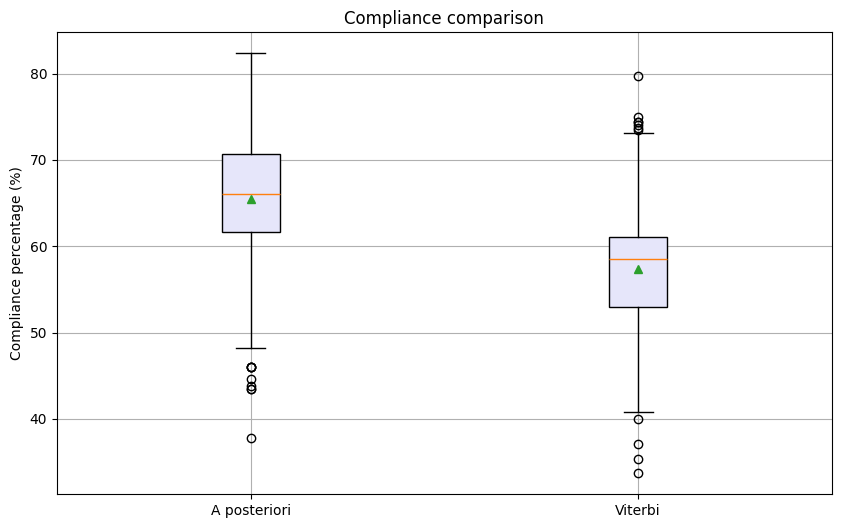

In [94]:
def aposterior(F, B, P_x):

    L = F.shape[1]  
    posterior_path = []

    for i in range(L):
        posterior_probabilities = [F[s, i] * B[s, i] / P_x for s in range(2)]
        most_probable_state = np.argmax(posterior_probabilities)
        posterior_path.append('P' if most_probable_state == 0 else 'N')

    return ''.join(posterior_path)

posterior_accuracies = []
viterbi_accuracies = []

for _, sequence, structure in data:
    original_path = convert(structure)

    F = forward(sequence, A, E)
    B = backward(sequence, A, E)

    P_x = sum(F[:, -1])

    posterior_path = aposterior(F, B, P_x)
    viterbi_path = viterbi(sequence, A, E)

    posterior_accuracy = sum(1 for p, t in zip(posterior_path, original_path) if p == t) / len(original_path) * 100
    posterior_accuracies.append(posterior_accuracy)

    viterbi_accuracy = sum(1 for p, t in zip(viterbi_path, original_path) if p == t) / len(original_path) * 100
    viterbi_accuracies.append(viterbi_accuracy)

plt.figure(figsize=(10, 6))
plt.boxplot([posterior_accuracies, viterbi_accuracies], patch_artist=True, showmeans=True, boxprops=dict(facecolor="#E6E6FA"))
plt.title("Compliance comparison")
plt.ylabel("Compliance percentage (%)")
plt.xticks([1, 2], ["A posteriori", "Viterbi"])
plt.grid(True)
plt.show()



Ocena 5.0

Przygotuj kod do tworzenia wizualizacji wartości prawdopodobieństw a posteriori, że stan to P wzdłuż podanej sekwencji. Dodatkowo oznacz miejsca, w których prawdziwy stan to P . Pokaż wizualizację dla dwóch wybranych sekwencji: w której ścieżka a posteriori jest najbardziej i najmniej zbliżona do prawdziwej.

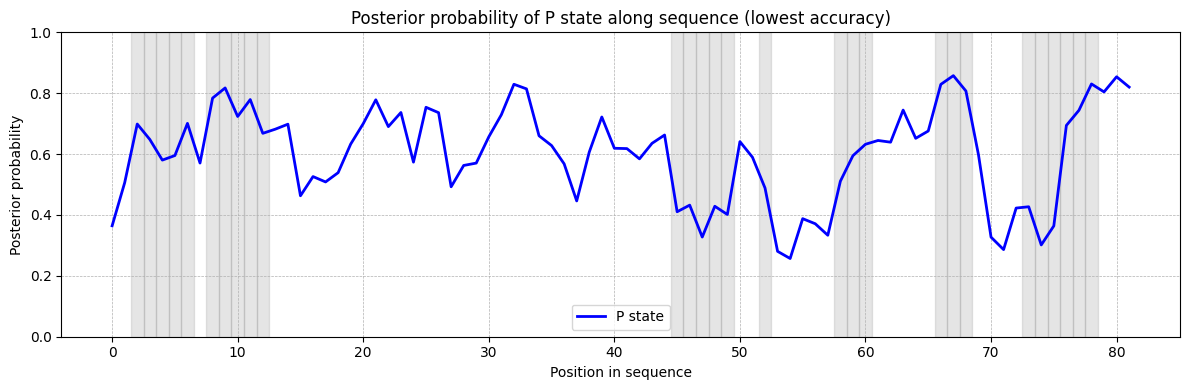

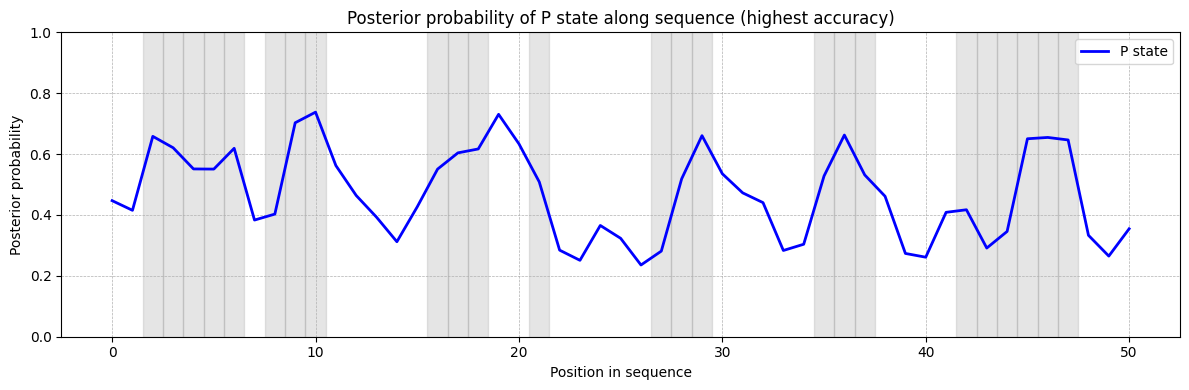

In [ ]:
import matplotlib.pyplot as plt

def plot_posterior(sequence, original_path, posterior_probs, title):
    positions = range(len(sequence))

    plt.figure(figsize=(12, 4))
    plt.plot(positions, posterior_probs, label="P state", color="blue", lw=2)

    if len(original_path) == len(sequence):
        for i, state in enumerate(original_path):
            if state == 'P':
                plt.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.2)
    else:
        print("Warning: Length mismatch between sequence and original_path")

    plt.title(title)
    plt.xlabel("Position in sequence")
    plt.ylabel("Posterior probability")
    plt.ylim(0, 1)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

results = sorted(results, key=lambda x: x[0])

min_accuracy_result = results[0]
plot_posterior(
    sequence=min_accuracy_result[1],
    original_path=min_accuracy_result[2],
    posterior_probs=min_accuracy_result[3],
    title="Posterior probability of P state along sequence (lowest accuracy)"
)

max_accuracy_result = results[-1]
plot_posterior(
    sequence=max_accuracy_result[1],
    original_path=max_accuracy_result[2],
    posterior_probs=max_accuracy_result[3],
    title="Posterior probability of P state along sequence (highest accuracy)"
)